In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
import itertools
from math import factorial
from collections import defaultdict

import time
import os
import ast
import multiprocessing

%load_ext google.cloud.bigquery

# 1. Data Load

In [2]:
%%bigquery df

WITH clean AS 
(
SELECT 
  DISTINCT full_visitor_id , client_id , organization_uuid , country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created , 
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  COUNT(DISTINCT organization_uuid) OVER(PARTITION BY full_visitor_id ) as nr_unique_uuid
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
WHERE full_visitor_id NOT IN (--list of visitor id that has no client id and only one unique (NA) uuid and 
                          SELECT
                              full_visitor_id 
                          FROM (
                                SELECT
                                    DISTINCT full_visitor_id , client_id , organization_uuid  ,
                                    DENSE_RANK() OVER(PARTITION BY full_visitor_id ORDER BY client_id DESC, organization_uuid DESC) as rank_entry 
                                    #optimize the code by group by and array_agg()?
                                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                WHERE full_visitor_id IN (SELECT 
                                                            DISTINCT full_visitor_id
                                                          FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                                          WHERE client_id IS NULL AND organization_uuid IS NULL
                                                          )
                                #ORDER BY full_visitor_id , rank_entry
                                      )
                          WHERE rank_entry = 1
                          AND client_id IS NULL
                          AND organization_uuid IS NULL
                          ) 
), 
ga_processed AS (
--delete row with no uuid and nr_unique_uuid per group of visitor id of that row > 1 
-- and fill NA uuid cells (Expected: rows with NA uuid and nr_unique_uuid =0 left)--
SELECT 
  full_visitor_id , client_id , organization_uuid , 
  IFNULL(organization_uuid, MAX(organization_uuid) OVER(PARTITION BY full_visitor_id)) as fill_uuid ,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  nr_unique_uuid
FROM clean
WHERE 
  organization_uuid IS NOT NULL
  #OR
  #(organization_uuid IS NULL  
  #AND nr_unique_uuid = 0 AND client_id IS NOT NULL) 
  OR
  (organization_uuid IS NULL AND nr_unique_uuid <= 1)
),
merged_campaign AS(
SELECT
  full_visitor_id , 
  IFNULL(fill_uuid, MAX(campaign_data.organization_uuid) OVER(PARTITION BY client_id)) as fill_uuid_2,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3, traffic_source_source, traffic_source_medium
FROM ga_processed
LEFT JOIN (SELECT
              DISTINCT google_analytics_id , organization_uuid 
           FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
           WHERE google_analytics_id IN (
                                         SELECT DISTINCT google_analytics_id
                                         FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
                                         GROUP BY google_analytics_id 
                                         HAVING COUNT(DISTINCT organization_uuid) = 1
                                         ) 
          ) AS campaign_data
ON ga_processed.client_id = campaign_data.google_analytics_id 
),
merged_oc AS (
--customer journey of merchants until registration tracked by ga cookies--
SELECT
  ft.fill_uuid_2 as organization_uuid , oc.organization_created ,
  ft.full_visitor_id, ft.country_id , ft.session_id , ft.session_start_time , ft.session_end_time ,
  ft.session_reached_minimal_created ,
  ft.traffic_source_level_3,
  traffic_source_source, traffic_source_medium
FROM merged_campaign ft
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON ft.fill_uuid_2 =oc.organization_uuid 
WHERE fill_uuid_2 IS NOT NULL
AND oc.organization_created >= ft.session_start_time 
)
SELECT
  uuid_left.organization_uuid ,
  uuid_left.organization_created ,
  #uuid_left.traffic_source_level_3 as traffic_source_level_3_af ,
  #merged_oc.full_visitor_id, 
  uuid_left.country_id , 
  merged_oc.session_id , merged_oc.session_start_time , merged_oc.session_end_time ,
  merged_oc.session_reached_minimal_created ,
  #merged_oc.traffic_source_level_3,
  #merged_oc.traffic_source_source, merged_oc.traffic_source_medium,
  IFNULL(merged_oc.traffic_source_level_3, uuid_left.traffic_source_level_3) as traffic_source_full
FROM (
      SELECT 
        af.organization_uuid, oc.country_id,
        af.traffic_source_level_3 , oc.organization_created 
      FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
      JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
      ON af.organization_uuid = oc.organization_uuid 
      AND oc.organization_created >= '2017-09-01'
      ) as uuid_left
LEFT JOIN merged_oc
ON uuid_left.organization_uuid = merged_oc.organization_uuid 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736765 entries, 0 to 1736764
Data columns (total 8 columns):
organization_uuid                  object
organization_created               datetime64[ns, UTC]
country_id                         object
session_id                         object
session_start_time                 object
session_end_time                   object
session_reached_minimal_created    object
traffic_source_full                object
dtypes: datetime64[ns, UTC](1), object(7)
memory usage: 106.0+ MB


In [4]:
%%bigquery df_af
SELECT 
  af.organization_uuid,
  oc.organization_created,
  oc.country_id,
  af.traffic_source_level_3 as traffic_source_full
FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON oc.organization_uuid = af.organization_uuid
WHERE oc.organization_created >= '2017-09-01' 

In [5]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136918 entries, 0 to 1136917
Data columns (total 4 columns):
organization_uuid       1136918 non-null object
organization_created    1136918 non-null datetime64[ns, UTC]
country_id              1136918 non-null object
traffic_source_full     1136918 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 34.7+ MB


# 2. Data Cleaning

1. Some uuid (from GA tracking) cannt be traced the last touch point in GA. Pulling these last touch point from attribution_funnel

2. Convert data types to correct ones

In [15]:
uuid_notmiss_lasttouch = list(df[df['session_reached_minimal_created'] == True]['organization_uuid'].unique()) + list(df[df['session_reached_minimal_created'].isna()]['organization_uuid'].unique())

In [7]:
df_concat_1 = df_af[~df_af['organization_uuid'].isin(uuid_notmiss_lasttouch)]
df_concat_1['session_start_time'] = ''
df_concat_1['session_end_time'] = ''

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
df_concat_2 = df[df['session_start_time'].isna()].loc[:,~df.columns.isin(['session_reached_minimal_created','session_id'])]
df_concat_2['session_start_time'] = ''
df_concat_2['session_end_time'] = ''


In [9]:
df_concat_2['session_start_time'] = ''
df_concat_2['session_end_time'] = ''

In [10]:
df_concat_3 = df[~df['session_start_time'].isna()].loc[:,~df.columns.isin(['session_reached_minimal_created','session_id'])]

In [11]:
print(df_concat_1.info())
print(df_concat_2.info())
print(df_concat_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40068 entries, 9 to 1136850
Data columns (total 6 columns):
organization_uuid       40068 non-null object
organization_created    40068 non-null datetime64[ns, UTC]
country_id              40068 non-null object
traffic_source_full     40068 non-null object
session_start_time      40068 non-null object
session_end_time        40068 non-null object
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 432660 entries, 0 to 432659
Data columns (total 6 columns):
organization_uuid       432660 non-null object
organization_created    432660 non-null datetime64[ns, UTC]
country_id              432660 non-null object
session_start_time      432660 non-null object
session_end_time        432660 non-null object
traffic_source_full     432660 non-null object
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 23.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304105

In [12]:
df_full = pd.concat([df_concat_1,df_concat_2, df_concat_3], axis = 0, ignore_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [13]:
df_full = df_full.assign(session_start_time = pd.to_datetime(df_full['session_start_time'], errors='coerce', utc=True),
                        session_end_time = pd.to_datetime(df_full['session_end_time'], errors='coerce',utc=True))

In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776833 entries, 0 to 1776832
Data columns (total 6 columns):
country_id              object
organization_created    datetime64[ns, UTC]
organization_uuid       object
session_end_time        datetime64[ns, UTC]
session_start_time      datetime64[ns, UTC]
traffic_source_full     object
dtypes: datetime64[ns, UTC](3), object(3)
memory usage: 81.3+ MB


# 3. Data Preparation

A journey = sub journeys (each sub journey = 1 month)

Create a new conversion column for each sub journey ( 0 = not conversion; 1 = conversion)

Steps:
1. Seperate the dataset into two parts:
    - One: merchants with only one session in their journey (1)
    - Other: metchants with more than one session in their journey (2)
    
    
2. The part (1): create a conversion column
3. The part (2): 
    - Identify the start journey point merchants
    - Calculate the journey length
    - Group touch points into subjourneys
    - Create a conversion for each sub journey

In [16]:
nr_sessions = pd.DataFrame(df_full.groupby('organization_uuid')['organization_uuid'].count())
nr_sessions.rename(columns={'organization_uuid':'nr_sessions'},inplace=True)
nr_sessions.sort_values('nr_sessions')

,nr_sessions
organization_uuid,
7fd85d00-93e5-11e8-9de1-d9605ac2973a,1
9f524c70-f373-11e8-8c93-8dd7f7ce7b28,1
9f5253c0-8111-11e8-88fd-b2fe88ff68b4,1
9f527420-a49a-11e8-a4d8-bf43eb4e8124,1
9f527800-9e4a-11e7-83b8-c34610a653d6,1
...,...
5b92e210-83a7-11e8-b97e-67561a58be5b,165
b17ed82c-ee78-11e9-ba52-797b7085c73f,168
acb46f80-2d06-11e8-b345-26cafa5be1d8,176


In [17]:
uuid_one_session = df_full[~df_full.organization_uuid.isin(nr_sessions[nr_sessions['nr_sessions'] != 1].index)]

In [18]:
uuid_more_session = df_full[df_full.organization_uuid.isin(nr_sessions[nr_sessions['nr_sessions'] != 1].index)]

Create a new field: conversion for each new dataset: uuid_one_session and uuid_more_session

*uuid_one_session*

In [19]:
uuid_one_session = uuid_one_session.assign(conversion = 1)

In [20]:
uuid_one_session.head()

,country_id,organization_created,organization_uuid,session_end_time,session_start_time,traffic_source_full,conversion
40068,NL,2019-04-30 15:23:06.734000+00:00,daba4a96-6b5b-11e9-abfe-b30f40658670,NaT,NaT,ds_keyaccount_sdk,1
40069,GB,2017-11-08 11:53:01.040000+00:00,5ee86700-c47b-11e7-8f04-8abe8e36d339,NaT,NaT,ds_keyaccount_sdk,1
40070,BR,2017-10-02 22:03:28.846000+00:00,857f4ee0-a7bd-11e7-ab01-476d1bdea5d9,NaT,NaT,ps_other_isc,1
40071,BR,2018-04-26 22:02:47.583000+00:00,8dff92f0-499d-11e8-be1c-eb902c89925b,NaT,NaT,ps_other_isc,1
40072,MX,2019-07-28 23:45:28.611000+00:00,c7735f00-b191-11e9-adff-0eb64c460167,NaT,NaT,ps_other_isc,1


*uuid_more_session*

In [21]:
uuid_more_session_group = pd.DataFrame(uuid_more_session.groupby(['organization_uuid','organization_created'])['session_start_time'].min())
uuid_more_session_group.reset_index(inplace=True)
uuid_more_session_group.rename(columns={'session_start_time':'journey_start'}, inplace=True)

In [22]:
uuid_more_session_group['journey_days'] = (uuid_more_session_group['organization_created'] - uuid_more_session_group['journey_start']).dt.days 

In [23]:
uuid_more_session_2 = uuid_more_session.merge(uuid_more_session_group[['organization_uuid','journey_start','journey_days']], how = 'left', left_on='organization_uuid', right_on='organization_uuid')

In [24]:
threshold = 31
uuid_more_session_2['sub_journey_no'] = np.nan
for i in tqdm_notebook(range(0,uuid_more_session_2.shape[0])):
    if uuid_more_session_2['journey_days'].iloc[i] < threshold:
        uuid_more_session_2['sub_journey_no'].iloc[i] = 1
    else:
        if uuid_more_session_2['session_start_time'].iloc[i] is pd.NaT:
            uuid_more_session_2['sub_journey_no'].iloc[i] = uuid_more_session_2['journey_days'].iloc[i]//threshold + 1
        else:
            uuid_more_session_2['sub_journey_no'].iloc[i] = (uuid_more_session_2['session_start_time'].iloc[i] - uuid_more_session_2['journey_start'].iloc[i]).days//threshold + 1
                                                                                  

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
uuid_more_session_2['conversion'] = np.nan
for i in tqdm_notebook(range(0, uuid_more_session_2.shape[0])):
    if uuid_more_session_2['sub_journey_no'].iloc[i] == 1 + uuid_more_session_2['journey_days'].iloc[i]//threshold:
        uuid_more_session_2['conversion'].iloc[i] = 1
    else: uuid_more_session_2['conversion'].iloc[i] = 0           
        

In [26]:
uuid_more_session_2[uuid_more_session_2['journey_days'] > 30].sort_values(['organization_uuid',
                                                                           'session_start_time']).head(10)

,country_id,organization_created,organization_uuid,session_end_time,session_start_time,traffic_source_full,journey_start,journey_days,sub_journey_no,conversion
313871,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2017-12-20 09:55:03+00:00,2017-12-20 09:44:49+00:00,o_organic_direct,2017-12-20 09:44:49+00:00,182,1.0,0.0
313869,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2017-12-20 09:58:49+00:00,2017-12-20 09:55:51+00:00,o_organic_referral,2017-12-20 09:44:49+00:00,182,1.0,0.0
313865,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2018-02-21 15:04:18+00:00,2018-02-21 15:02:11+00:00,o_organic_seo,2017-12-20 09:44:49+00:00,182,3.0,0.0
313870,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2018-04-12 07:54:43+00:00,2018-04-12 07:53:12+00:00,o_organic_referral,2017-12-20 09:44:49+00:00,182,4.0,0.0
313867,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2018-04-12 07:54:59+00:00,2018-04-12 07:54:57+00:00,ps_pay_sdk,2017-12-20 09:44:49+00:00,182,4.0,0.0
313868,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2018-04-12 07:55:10+00:00,2018-04-12 07:55:10+00:00,o_organic_referral,2017-12-20 09:44:49+00:00,182,4.0,0.0
313864,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2018-04-20 08:15:10+00:00,2018-04-20 08:12:44+00:00,o_organic_null,2017-12-20 09:44:49+00:00,182,4.0,0.0
313866,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2018-06-21 08:29:06+00:00,2018-06-21 08:20:47+00:00,o_organic_null,2017-12-20 09:44:49+00:00,182,6.0,1.0
773135,GB,2018-06-21 08:35:06.385000+00:00,00019810-752e-11e8-87be-f10a39ba2679,2018-06-21 08:55:01+00:00,2018-06-21 08:31:37+00:00,o_organic_referral,2017-12-20 09:44:49+00:00,182,6.0,1.0
653335,NO,2019-01-25 11:40:22.882000+00:00,0001f5d0-2096-11e9-aec7-6ff0f8005d17,2018-01-27 16:16:49+00:00,2018-01-27 16:00:53+00:00,o_organic_seo,2018-01-27 16:00:53+00:00,362,1.0,0.0


**Regroup traffic sources**

In [27]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                 'ps_other_isc':'partnerships', 'pp_paypal_paypal':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    df['traffic_source'] = ''
    for i in tqdm_notebook(range(0, df.shape[0])):
        if df.traffic_source_full.iloc[i] in list(dict_channels.keys()):
            df['traffic_source'].iat[i] = dict_channels[df.traffic_source_full.iloc[i]]
        else: df['traffic_source'].iat[i] = df['traffic_source_full'].iat[i]

In [28]:
map_value(uuid_one_session)
map_value(uuid_more_session_2)

In [29]:
print(uuid_more_session_2.traffic_source.unique())
print(uuid_one_session.traffic_source.unique())


['direct' 'o_paid_sem' 'partnerships' 'o_organic_app' 'o_organic_seo'
 'o_organic_null' 'o_organic_direct' 'o_organic_invite' 'o_paid_affiliate'
 'o_organic_referral' 'o_paid_social' 'o_paid_app_install']
['direct' 'partnerships' 'o_paid_sem' 'o_organic_app' 'o_organic_seo'
 'o_paid_social' 'o_organic_null' 'o_organic_direct' 'o_organic_invite'
 'o_paid_affiliate' 'o_organic_referral' 'o_paid_app_install']


**For each merchant, create a journey pathway into a list.**

*uuid_more_session*

In [30]:
uuid_more_session_2.drop(['session_end_time','session_start_time','traffic_source_full'],axis = 1,inplace=True)

In [31]:
uuid_more_session_journey = pd.DataFrame(uuid_more_session_2.groupby(['organization_uuid',
                                                                      'sub_journey_no'])['traffic_source'].apply(list))
uuid_more_session_journey.reset_index(inplace = True)
uuid_more_session_journey.rename(columns = {'traffic_source':'journey'}, inplace = True)

In [32]:
uuid_more_session_journey['unique_touchpoints'] = [sorted(list(set(i))) for i in uuid_more_session_journey['journey']]

In [33]:
uuid_more_session_table1 = uuid_more_session_journey[['organization_uuid',
                                                      'sub_journey_no',
                                                      'unique_touchpoints']].merge(df_af[['organization_uuid','country_id','organization_created']], 
                                                                                   how ='left', 
                                                                                   left_on = 'organization_uuid', right_on = 'organization_uuid')



In [34]:
subjourney_conversion = pd.DataFrame(uuid_more_session_2.groupby(['organization_uuid','sub_journey_no'])['conversion'].max()).reset_index()

In [35]:
uuid_more_session_table1 = uuid_more_session_table1.merge(subjourney_conversion, how = 'left', 
                                                          left_on= ('organization_uuid','sub_journey_no'), 
                                                          right_on = ('organization_uuid','sub_journey_no'))

In [36]:
uuid_more_session_table1.sort_values('organization_uuid')

,organization_uuid,sub_journey_no,unique_touchpoints,country_id,organization_created,conversion
0,00000d7a-905c-11e9-9233-ae9d68e66093,1.0,[o_paid_sem],GB,2019-06-16 17:27:22.290000+00:00,1.0
1,00001110-992a-11e7-9808-8ab8ae4b9c97,1.0,"[o_organic_seo, o_paid_sem]",SE,2017-09-14 08:52:12.577000+00:00,1.0
2,000025a0-4885-11e8-b4f3-557d531c63b3,1.0,[o_paid_sem],GB,2018-04-25 12:34:30.266000+00:00,1.0
3,00003480-755a-11e8-941a-f4245c6e2118,1.0,"[o_organic_seo, o_paid_sem]",GB,2018-06-21 13:50:04.232000+00:00,1.0
4,0000e470-22df-11e8-b107-f6fb37cbda60,1.0,"[o_organic_direct, o_paid_sem]",GB,2018-03-08 14:43:00.791000+00:00,1.0
...,...,...,...,...,...,...
317184,fffef510-ad09-11e8-abfb-fca54534ad75,1.0,[o_paid_affiliate],GB,2018-08-31 10:38:29.601000+00:00,1.0
317185,ffff4820-c336-11e7-85dd-8d1dfe21b117,1.0,[direct],DE,2017-11-06 21:11:04.866000+00:00,1.0
317187,ffff6020-7949-11e8-a024-bde930820437,2.0,[o_paid_sem],GB,2018-06-26 14:05:36.930000+00:00,1.0
317186,ffff6020-7949-11e8-a024-bde930820437,1.0,[o_paid_sem],GB,2018-06-26 14:05:36.930000+00:00,0.0


*uuid_one_session*

In [37]:
unique_touchpoints = [[uuid_one_session['traffic_source'].iloc[i]] for i in tqdm_notebook(range(0, uuid_one_session.shape[0]))]
uuid_one_session['unique_touchpoints'] = unique_touchpoints

In [38]:
uuid_one_session['sub_journey_no'] = 1.0
uuid_one_session_table1 = uuid_one_session[['organization_uuid',
                                     'sub_journey_no',
                                     'unique_touchpoints',
                                     'country_id', 
                                     'organization_created', 
                                     'conversion']]
uuid_one_session_table1.head()

,organization_uuid,sub_journey_no,unique_touchpoints,country_id,organization_created,conversion
40068,daba4a96-6b5b-11e9-abfe-b30f40658670,1.0,[direct],NL,2019-04-30 15:23:06.734000+00:00,1
40069,5ee86700-c47b-11e7-8f04-8abe8e36d339,1.0,[direct],GB,2017-11-08 11:53:01.040000+00:00,1
40070,857f4ee0-a7bd-11e7-ab01-476d1bdea5d9,1.0,[partnerships],BR,2017-10-02 22:03:28.846000+00:00,1
40071,8dff92f0-499d-11e8-be1c-eb902c89925b,1.0,[partnerships],BR,2018-04-26 22:02:47.583000+00:00,1
40072,c7735f00-b191-11e9-adff-0eb64c460167,1.0,[partnerships],MX,2019-07-28 23:45:28.611000+00:00,1


In [39]:
print(uuid_one_session_table1.info())
print(uuid_more_session_table1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875202 entries, 40068 to 1776832
Data columns (total 6 columns):
organization_uuid       875202 non-null object
sub_journey_no          875202 non-null float64
unique_touchpoints      875202 non-null object
country_id              875202 non-null object
organization_created    875202 non-null datetime64[ns, UTC]
conversion              875202 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(3)
memory usage: 46.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 317189 entries, 0 to 317188
Data columns (total 6 columns):
organization_uuid       317189 non-null object
sub_journey_no          317189 non-null float64
unique_touchpoints      317189 non-null object
country_id              317189 non-null object
organization_created    317189 non-null datetime64[ns, UTC]
conversion              317189 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 16.9+ MB
None


In [40]:
basetable = pd.concat([uuid_one_session_table1, uuid_more_session_table1], axis = 0, ignore_index=True)

In [41]:
basetable.head()

,organization_uuid,sub_journey_no,unique_touchpoints,country_id,organization_created,conversion
0,daba4a96-6b5b-11e9-abfe-b30f40658670,1.0,[direct],NL,2019-04-30 15:23:06.734000+00:00,1.0
1,5ee86700-c47b-11e7-8f04-8abe8e36d339,1.0,[direct],GB,2017-11-08 11:53:01.040000+00:00,1.0
2,857f4ee0-a7bd-11e7-ab01-476d1bdea5d9,1.0,[partnerships],BR,2017-10-02 22:03:28.846000+00:00,1.0
3,8dff92f0-499d-11e8-be1c-eb902c89925b,1.0,[partnerships],BR,2018-04-26 22:02:47.583000+00:00,1.0
4,c7735f00-b191-11e9-adff-0eb64c460167,1.0,[partnerships],MX,2019-07-28 23:45:28.611000+00:00,1.0


In [42]:
basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192391 entries, 0 to 1192390
Data columns (total 6 columns):
organization_uuid       1192391 non-null object
sub_journey_no          1192391 non-null float64
unique_touchpoints      1192391 non-null object
country_id              1192391 non-null object
organization_created    1192391 non-null datetime64[ns, UTC]
conversion              1192391 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 54.6+ MB


# 4. Modelling

**For each unique journey (here: unique_touchpoints), count the number of conversion**

In [43]:
def touchpoints_conversion(df):
    '''
    This function returns all unique journeys of customers up to REG 
    and the number of conversion of each journey.
    
    Input:
        - df: basetable
    '''
    
    df['unique_touchpoints_str'] = [",".join(i) for i in df['unique_touchpoints']]
    subset_conversion = pd.DataFrame(df.groupby('unique_touchpoints_str')['conversion'].sum())
    return subset_conversion

In [44]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return map(",".join,map(sorted,sub_channels))

In [45]:
def attribution(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A.split(","))
    worth_of_A=0
    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]
    return worth_of_A

In [46]:
def shapley_model(channels,df):
    C_values = df.to_dict()['conversion']
    
    v_values = {}
    for A in subsets(channels):
        v_values[A] = attribution(A,C_values)
    
    n=len(channels)
    shapley_values = defaultdict(int)

    for channel in channels:
        for A in v_values.keys():
            if channel not in A.split(","):
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                shapley_values[channel] += (v_values[A_with_channel]-v_values[A])*(factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 

    shapley_values_df = pd.DataFrame.from_dict(shapley_values, orient = 'index')
    shapley_values_df.rename(columns = {0 : 'nr_conversion'}, inplace = True)
    shapley_values_df['conversion_rate'] = shapley_values_df['nr_conversion']/shapley_values_df['nr_conversion'].sum()
    
    shapley_values_df.sort_values('conversion_rate')['conversion_rate'].plot.barh(color = 'mediumpurple',
                                                                 figsize = (10,8))
    plt.xticks(rotation = 0)
    plt.legend('')
    plt.ylabel('number of conversion')
    plt.title('channels attribution')
    plt.show()
    
    return shapley_values_df

In [47]:
channels = set(list(uuid_more_session_2['traffic_source'].unique()) + list(uuid_one_session['traffic_source'].unique()))
channels = list(channels)

## 4.1 Global level

### 4.1.1 All uuid

In [48]:
basetable_global = touchpoints_conversion(basetable)
basetable_global.sort_values('conversion', ascending=False).head(20)

,conversion
unique_touchpoints_str,
o_paid_sem,284965.0
o_organic_null,156947.0
o_organic_direct,144644.0
o_organic_app,100692.0
o_organic_seo,95525.0
partnerships,62750.0
o_paid_social,56141.0
o_paid_affiliate,47631.0
"o_organic_seo,o_paid_sem",27219.0


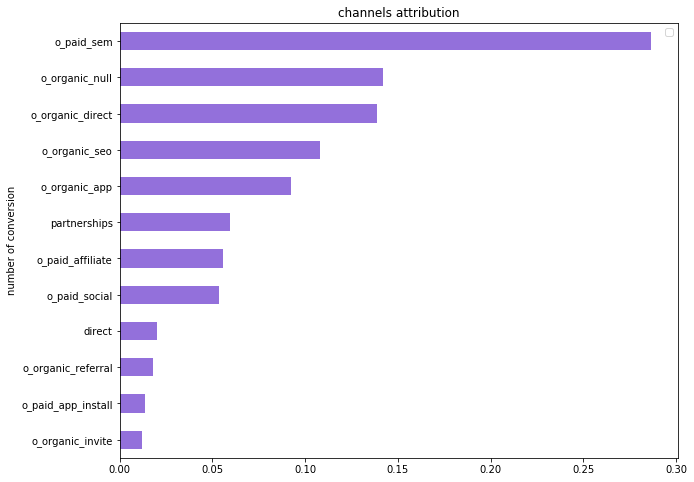

In [49]:
shapley_values_global = shapley_model(channels,basetable_global)

In [50]:
shapley_values_global

,nr_conversion,conversion_rate
direct,22973.142857,0.020209
partnerships,67315.676190,0.059215
o_organic_app,104980.433333,0.092347
o_organic_seo,122749.442857,0.107978
o_paid_social,60822.266667,0.053503
o_organic_direct,157951.626190,0.138944
o_paid_app_install,15585.616667,0.013710
o_organic_invite,13404.516667,0.011791
o_paid_affiliate,63387.526190,0.055760
o_organic_null,161610.759524,0.142163


### 4.1.2 Only trackable uuid by GA

In [51]:
list_not_ga = df_full[~df_full['session_start_time'].isna()]
basetable_uuid_ga = basetable[basetable['organization_uuid'].isin(list_not_ga['organization_uuid'].unique())]

In [52]:
basetable_global_uuid_ga = touchpoints_conversion(basetable_uuid_ga)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


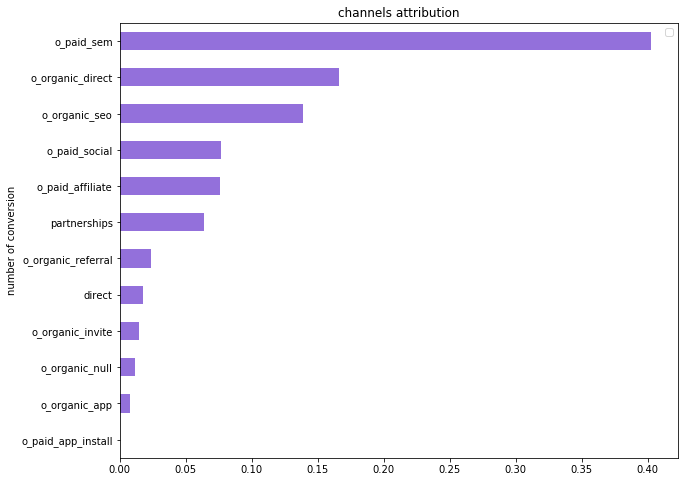

In [53]:
shapley_values_global_uuid_ga = shapley_model(channels, basetable_global_uuid_ga)

In [54]:
shapley_values_global_uuid_ga

,nr_conversion,conversion_rate
direct,12476.142857,0.017718
partnerships,44865.676190,0.063717
o_organic_app,5615.433333,0.007975
o_organic_seo,97641.442857,0.138668
o_paid_social,53847.266667,0.076473
o_organic_direct,117170.626190,0.166403
o_paid_app_install,169.616667,0.000241
o_organic_invite,10230.516667,0.014529
o_paid_affiliate,53557.526190,0.076061
o_organic_null,8167.759524,0.011600


## 4.3 Monthly basic

In [55]:
basetable_m = basetable.copy()

In [57]:
basetable_m['year_month_created'] = basetable['organization_created'].dt.to_period('M')
#basetable_m['month_created'] = basetable['organization_created'].dt.month
#basetable_m['day_created'] = basetable['organization_created'].dt.day

//anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [71]:
def shapley_model_month(channels,df):
    C_values = df.to_dict()['conversion']
    
    v_values = {}
    for A in subsets(channels):
        v_values[A] = attribution(A,C_values)
    
    n=len(channels)
    shapley_values = defaultdict(int)

    for channel in channels:
        for A in v_values.keys():
            if channel not in A.split(","):
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                shapley_values[channel] += (v_values[A_with_channel]-v_values[A])*(factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 

    shapley_values_df = pd.DataFrame.from_dict(shapley_values, orient = 'index')
    shapley_values_df.rename(columns = {0 : 'nr_conversion'}, inplace = True)
    shapley_values_df['conversion_rate'] = shapley_values_df['nr_conversion']/shapley_values_df['nr_conversion'].sum()
    
    return shapley_values_df[['conversion_rate']]

In [128]:
def month_attribution(df):
    shapley_df = pd.DataFrame()
    for year_month in list(df['year_month_created'].unique()):
        df_month = df[df['year_month_created'] == year_month]
        
        conversion = touchpoints_conversion(df_month)
        shapley_values = shapley_model_month(channels,conversion)
        shapley_values['year_month'] = year_month
        shapley_values.reset_index(inplace = True)
        print(year_month)
        
        shapley_df = pd.concat([shapley_df,shapley_values], axis = 0)
    return shapley_df.pivot(index = 'year_month', columns = 'index', values = 'conversion_rate')

In [129]:
shapley_values_month = month_attribution(basetable_m)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


2019-04
2017-11
2017-10
2018-04
2019-07
2018-09
2019-08
2019-01
2018-11
2019-06
2019-03
2018-12
2018-03
2019-02
2018-02
2018-10
2019-05
2017-09
2018-01
2018-06
2018-05
2017-12
2018-08
2019-10
2019-09
2018-07


In [140]:
a = shapley_values_month.sort_index()

In [141]:
a

index,direct,o_organic_app,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_app_install,o_paid_sem,o_paid_social,partnerships
year_month,,,,,,,,,,,,
2017-09,0.025622,0.010499,0.261955,0.031016,0.093677,0.018548,0.110589,0.042520,0.000410,0.246227,0.070480,0.088456
2017-10,0.028079,0.006225,0.300136,0.030955,0.025526,0.023060,0.118563,0.046083,0.000706,0.280453,0.077424,0.062790
2017-11,0.031611,0.009225,0.312192,0.030149,0.025217,0.024002,0.109466,0.048915,0.000741,0.268044,0.063203,0.077235
2017-12,0.020818,0.010213,0.333734,0.024269,0.026671,0.023069,0.094597,0.034867,0.000706,0.259328,0.087740,0.083989
2018-01,0.019234,0.012767,0.308330,0.021479,0.026012,0.020452,0.104391,0.041246,0.000772,0.295173,0.078112,0.072032
2018-02,0.019951,0.014082,0.301800,0.023880,0.023136,0.018497,0.114979,0.042452,0.000540,0.310562,0.062458,0.067664
2018-03,0.024735,0.018751,0.287738,0.023333,0.046460,0.019947,0.115216,0.060008,0.000459,0.280079,0.060745,0.062529
2018-04,0.018559,0.112808,0.145911,0.026455,0.106022,0.015851,0.115640,0.052959,0.005103,0.305303,0.031302,0.064086
2018-05,0.016976,0.145242,0.069259,0.019123,0.143780,0.015990,0.126347,0.047805,0.014257,0.297005,0.049271,0.054946


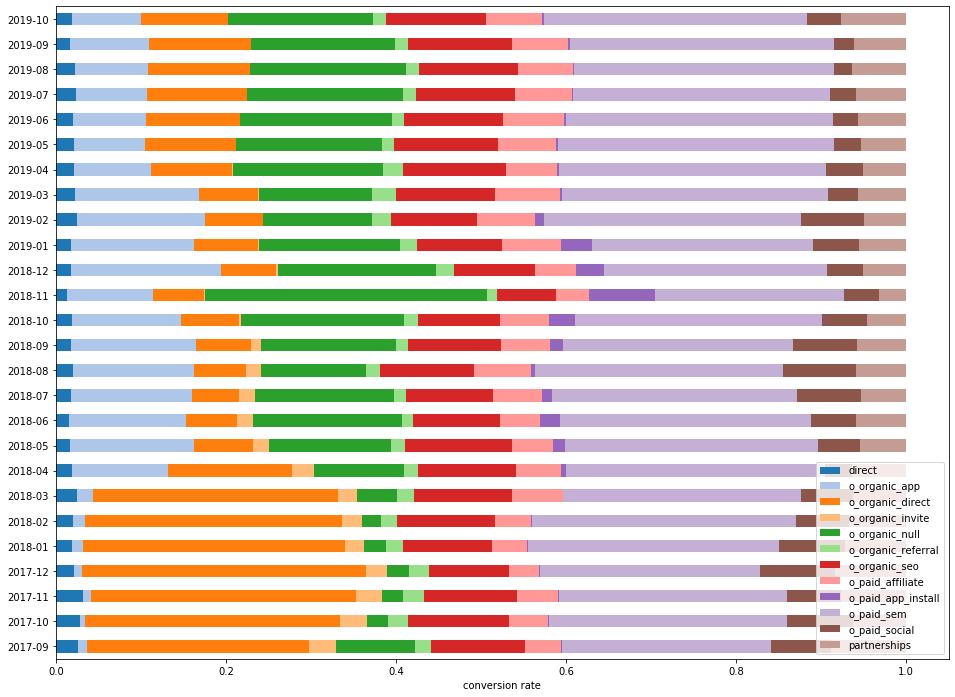

In [143]:
shapley_values_month.sort_index().plot.barh(stacked = True,
                                            rot = 0,
                                            figsize = (16,12),
                                            color = sns.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.show()

## 4.2 Europe

### 4.2.1 All merchants

In [145]:
country_europe = ['GB', 'SE', 'DE', 'NL', 'NO', 'FR', 'FI', 'DK', 'ES', 'IT']

In [146]:
europe = basetable[basetable['country_id'].isin(country_europe)]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


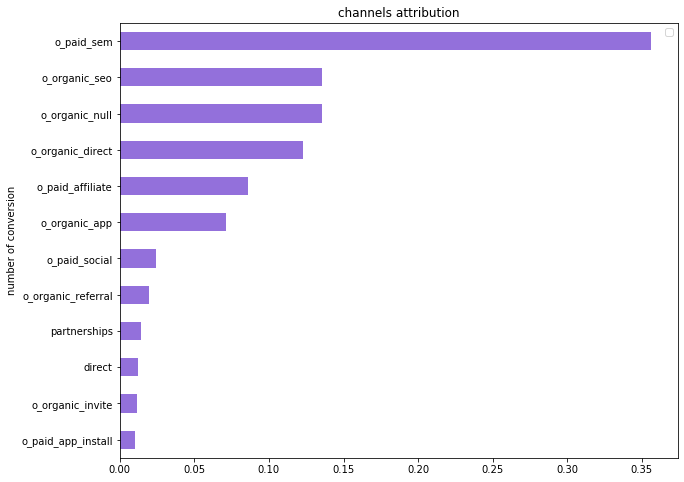

In [147]:
basetable_europe = touchpoints_conversion(europe)
shapley_values_europe = shapley_model(channels, basetable_europe)

In [148]:
shapley_values_europe

,nr_conversion,conversion_rate
direct,8376.692857,0.012037
partnerships,9742.176190,0.013999
o_organic_app,49421.233333,0.071016
o_organic_seo,94575.659524,0.135902
o_paid_social,17143.850000,0.024635
o_organic_direct,85623.876190,0.123038
o_paid_app_install,7147.783333,0.010271
o_organic_invite,8103.233333,0.011644
o_paid_affiliate,60033.176190,0.086265
o_organic_null,94243.026190,0.135424


### 4.2.2 Monthly basic

In [149]:
eu_m = europe.copy()
eu_m['year_month_created'] = basetable['organization_created'].dt.to_period('M')
shapley_values_eu_month = month_attribution(eu_m)

//anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


2019-04
2017-11
2018-01
2017-09
2018-02
2019-07
2018-03
2018-05
2018-08
2018-04
2019-09
2018-07
2019-06
2019-08
2019-01
2017-10
2019-05
2019-02
2019-10
2019-03
2018-11
2018-12
2018-10
2018-06
2018-09
2017-12


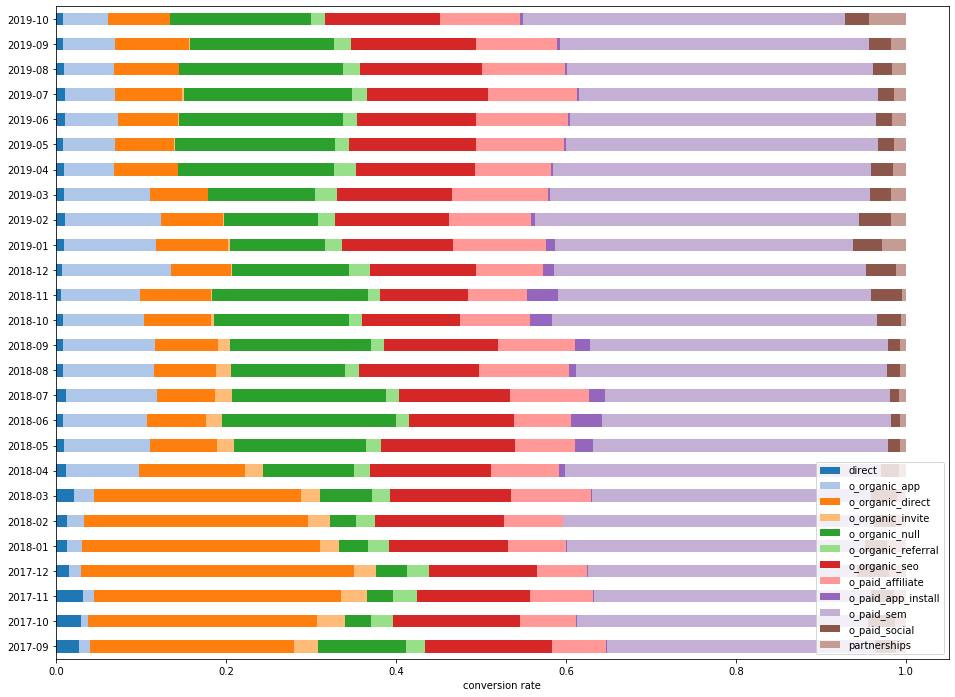

In [150]:
shapley_values_eu_month.sort_index().plot.barh(stacked = True,
                                            rot = 0,
                                            figsize = (16,12),
                                            color = sns.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.show()

In [151]:
shapley_values_eu_month.sort_index()

index,direct,o_organic_app,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_app_install,o_paid_sem,o_paid_social,partnerships
year_month,,,,,,,,,,,,
2017-09,0.027021,0.013575,0.239807,0.028247,0.103109,0.022472,0.148934,0.064066,0.000722,0.315004,0.025323,0.011722
2017-10,0.029026,0.008964,0.269298,0.032247,0.031516,0.025547,0.148707,0.066462,0.001259,0.342570,0.030981,0.013423
2017-11,0.032282,0.012219,0.290826,0.030991,0.029819,0.028076,0.133863,0.072970,0.001274,0.326722,0.027156,0.013802
2017-12,0.015599,0.013655,0.321183,0.026065,0.036026,0.026369,0.126455,0.058690,0.001366,0.316450,0.037574,0.020567
2018-01,0.012853,0.017569,0.280142,0.021755,0.034281,0.025102,0.140068,0.067510,0.001302,0.350706,0.026338,0.022376
2018-02,0.013111,0.019358,0.264508,0.025681,0.029956,0.022811,0.151268,0.069278,0.000870,0.364696,0.025886,0.012577
2018-03,0.021767,0.023040,0.243058,0.022277,0.062001,0.021023,0.142293,0.093941,0.000755,0.328690,0.030685,0.010471
2018-04,0.011496,0.086610,0.124266,0.021530,0.107051,0.018313,0.142029,0.080178,0.007786,0.371106,0.020863,0.008771
2018-05,0.008926,0.101968,0.078621,0.019724,0.155959,0.017262,0.157424,0.070470,0.021015,0.347761,0.013406,0.007462


## 4.4 Markets

## 4.5 Monthly basic and markets